# Determining the Tradeoff

### Introduction

### Loading the data

In [14]:

import pandas as pd
df = pd.read_csv('./coerced_customer_churn.csv', index_col = 0)

X = df.drop('Churn', axis = 1)
y = df['Churn']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size = .5)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = "lbfgs", max_iter = 5000).fit(X_train, y_train)

In [17]:
model.score(X_validate, y_validate)

0.8041163946061036

### Modifying the Threshold

In [18]:
from sklearn.metrics import precision_score, recall_score

In [32]:
recall_score(y_validate, model.predict(X_validate)), precision_score(y_validate, model.predict(X_validate))

(0.5211267605633803, 0.6357388316151202)

Now, let's try to improve our recall score, and thus detect more customers who will churn, by lowering our threshold for making a positive prediction.  We can do so, predicting those with a prob_a score of only .40 to be positive.  Let's do it.

In [29]:
threshold = .3

threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
threshold_preds[:3]

array([ True,  True, False])

Doing so should now increase our recall score, and decrease our precision score.

In [31]:
recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.7211267605633803, 0.5182186234817814)

### Plotting Precision and Recall Scores

Having the ability to balance precision and recall is a really practical skill.  For example, in this example, where we don't want customers to churn, there is obviously both a cost to losing the customer, as well as any efforts (like a discount) to retain her.  

This balancing act is made easier with the use of the `precision_recall_curve` function provided by sklearn.

In [40]:
from sklearn.metrics import precision_recall_curve
y_val_preds = model.predict_proba(X_validate)
precision, recall, thresholds = precision_recall_curve(y_validate, y_val_preds[:, 1])


In [64]:
precision.shape, thresholds.shape, recall.shape

((1307,), (1306,), (1307,))

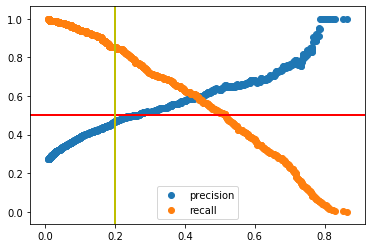

In [62]:
import matplotlib.pyplot as plt
plt.scatter(x = thresholds, y = precision[1:], label = 'precision')
plt.scatter(x = thresholds, y = recall[1:], label= 'recall')
plt.axhline(linewidth=2, color='r', y = .5)
plt.axvline(linewidth=2, color='y', x = .2)
plt.legend()

We can see from the plot above, that we can decrease our threshold to around .2, still maintain a precision of .5, and have a precision of around .85 or so.

### Solving with Code

Of course, to find the exact number we can loop through some different thresholds calculating the precision and accuracy for each one.

In [68]:
df = pd.DataFrame({'thresholds':thresholds, 'precision':precision[1:], 'recalls': recall[1:]})

In [69]:
df[:3]

,thresholds,precision,recalls
0,0.009790,0.271264,0.997183
1,0.009900,0.271472,0.997183
2,0.009993,0.271681,0.997183


In [73]:
df[(df['precision'] < .5001) & (df['precision'] > .4999)]

,thresholds,precision,recalls
743,0.253683,0.5,0.791549
745,0.254514,0.5,0.788732
747,0.256193,0.5,0.785915
759,0.265010,0.5,0.769014


So we can see that we can have a recall score of .79 if we all precision to drop to .5.  And we can do so with a threshold of .25.

So let's do this:

In [74]:
threshold = .254

threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
threshold_preds[:3]

recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.7915492957746478, 0.5)

And these are the related predictions.

In [76]:
threshold_preds.astype('int')[:5]

array([1, 1, 0, 1, 1])

### Wrapping Up

Finally, because precision and recall occur in tradeoffs, data scientists often use an average of precision and recall to summarize how well a model is performing on both of these metrics.  Except, the kind of average they use is called a harmonic mean.  The harmonic mean of precision and recall is the following: 

$F_1 = \frac{p*r}{p + r}$

In [77]:
from sklearn.metrics import f1_score

f1_score(y_validate, threshold_preds)

0.6128680479825518

> To find exactly where the harmonic mean peaks, we can again loop through various thresholds.

In [90]:
threshold_preds = (model.predict_proba(X_validate) > .24)[:, 1]
f1_score(y_validate, threshold_preds)

0.6147278548559232